<a href="https://colab.research.google.com/github/GilSasson/KeepMoving/blob/main/StocksFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Applications of Artificial Intelligence and Data Mining, Prof. Avi Rosenfeld.**
**Project:** Time series stock analysis

**Students:**

Gil Sasson

Dor Hayat

Maya Kaufman

# **Table of Contents**
1. Data setup (Apple) and stocks' indicators.
2. Decision Tree model.
3. Logistic Regression model.
4. Random Forest model.
5. Neural Network model using the stocks' indicators.
6. Neural Network model using the raw data.
7. Testing 1-6 on Amazon stocks.

## **1) Data setup and stocks' indicators**
First we'll create a binary field which indicates if the stocks' price went up or not the next day. In this work this step will be done manually in Excel but can be easily written in python. We'll then create more fields such as the day of the month and year. Using the raw data, we'll then write functions for some known stocks' price indicators such as RSI, OBV and SMA for two different time periods (we chose 2 & 4 days) and then substract them (substraction of the same indicator but different time periods) in order to get a broader view of the prices' behaviour and then show the relation, although weak, between the stocks' indicators to the aforementioned binary field with a simple graph.
## **2-3) Using Decision Tree and Logistic Regression**
We will use decision tree and logistic regression to predict if the stock price market for one of the FAANG companies goes the next day (we chose Apple).
## **4-6) RF & Using Keras to Build and Train Neural Networks**
We will start by training a Random Forest to get a performance baseline. Then we will use a neural network to predict if the stocks' price goes up the next day. We will use the Keras package to build and train the aforementioned neural network.
## **7) Testing 1-6 on Amazon stocks**
Running the same code with slight changes if there are no nulls rows in the data in the Amazon dataset.


# “FAANG” companies (Facebook, Amazon, Apple, Netflix, Google)   database
source: https://www.kaggle.com/aayushmishra1512/faang-complete-stock-data

# Attributes (raw data):

1. Open - opening price of the stock
2. High - max pice of the stock for the day
3. Low - min price of the stock for the day
4. Close - closing price of stock for the day
5. Volume - volume are the physical number of shares traded of that stock on a particular day
6. Raise - determines if the stocks' price went up the next day (0 or 1).

7. Adj Close - data is adjusted using appropriate split and dividend multipliers for the closing price for the day and can be thought of as a more accurate measure of stocks’ value. Therefore, we'll use the Adj Close values to determine if the stocks' price went up the next day. 



The “FAANG” companies dataset has 6 numerical predictors and a binary outcome.
We will add more indicators to the dataset such as RSI, Moving Averages, OBV, which we will talk about later in this work.

In [ ]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import plot_confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import seaborn as sns

%matplotlib inline

In [ ]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential
#from keras import backend as K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#Taken from tcoil [1] (See references)
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [ ]:
# From sentdex (Youtuber) [2] (See references)
def movingaverage(values,window):
  weights = np.repeat(1.0, window)/window
  smas = np.convolve(values, weights, mode='same')
  return smas

**1) Data Setup**

In [ ]:
#getting the dataset
url = 'https://raw.githubusercontent.com/GilSasson/ai/main/Apple.csv'
df=pd.read_csv(url,  header=0, error_bad_lines=False) 
#put data in dataset without header line
# rawdataset = np.array(df)

We modified our Apple.csv file as follows:
1. We created a binary field to show if the stock went up or down.
2. We created a day of the month field because of the strong dependant of the stock's price because of trading days, holidays, et cetera.

Note: This algorithm does not take into account other strong stock-related features such as entrepreneurs' twits, social media, news et cetera et cetera.

If there are lots of "NaN" you may have internet connectivity issues.

In [ ]:
#dropping null values if such exists from np and df

print("shape off dataframe before drop:",df.shape)
# print("shape of np before drop:",rawdataset.shape)
null_row = np.where(df['Low'].isnull()) 
# dataset = np.delete(rawdataset,(null_row[0][0]), axis=0)
# print("shape of np after drop:",dataset.shape)
df.drop(null_row[0][0], axis=0, inplace = True)
print("shape of dataframe after drop:",df.shape)
print("row where we found null is:")
nullrow = null_row[0][0] # we had a null row here
nullrow

shape off dataframe before drop: (10016, 11)
shape of dataframe after drop: (10015, 11)
row where we found null is:


165

In [ ]:
#Creating new features with our given data:
High = df['High'].to_numpy()
Low = df['Low'].to_numpy()
Mid = (High+Low)/2.0
Close = df['Close'].to_numpy()
Open = df['Open'].to_numpy()
Volume = df['Volume'].to_numpy()
df.insert(2, "Mid", Mid, True)
df['RSI_4'] = computeRSI(df['Adj Close'], 4)
df['RSI_2'] = computeRSI(df['Adj Close'], 2)

At the beginning of the dataframe there are no RSI values calculated, since we need to calculate them using sufficient time window (10 days), let us get rid of the NaN values!

In [ ]:
#dropping nan values if such exists from df

print("shape off dataframe before drop:",df.shape)
dfrowsold = df.shape[0] # will be used for OBV calc
df.dropna(subset = ["RSI_4"], inplace=True)
print("shape of dataframe after drop:",df.shape)
dfrowsnew = df.shape[0] # will be used for OBV calc

shape off dataframe before drop: (10015, 14)
shape of dataframe after drop: (10011, 14)


In [ ]:
#Creating new features with our given data:
df['SMA_4'] = movingaverage(df['Open'], 4)
df['SMA_2'] = movingaverage(df['Open'], 2)
df['SMA_SUB'] = df['SMA_4']-df['SMA_2']

Text(0, 0.5, 'SMA')

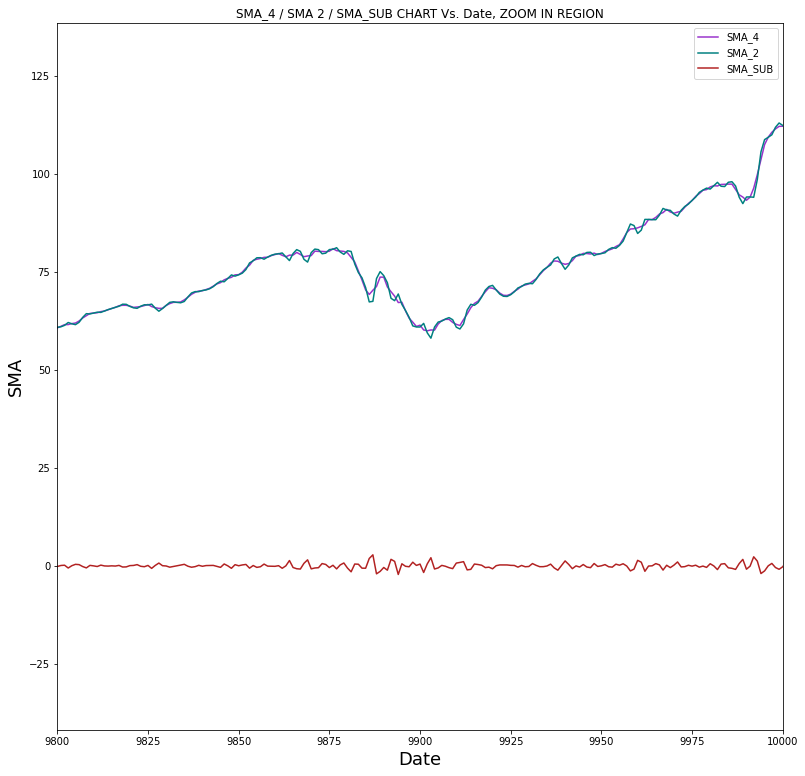

In [ ]:
#graphing SMA vs. Timeline
plt.figure(figsize=(13,13))
plt.title('SMA_4 / SMA 2 / SMA_SUB CHART Vs. Date, ZOOM IN REGION')
plt.plot(df['SMA_4'], label='SMA_4', color = 'darkorchid')
plt.plot(df['SMA_2'], label='SMA_2', color='teal')
plt.plot(df['SMA_SUB'], label='SMA_SUB', color='firebrick')
plt.xlim(9800,10000)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=18)
plt.ylabel('SMA', fontsize = 18)

Text(0, 0.5, 'SMA_SUB / Raise')

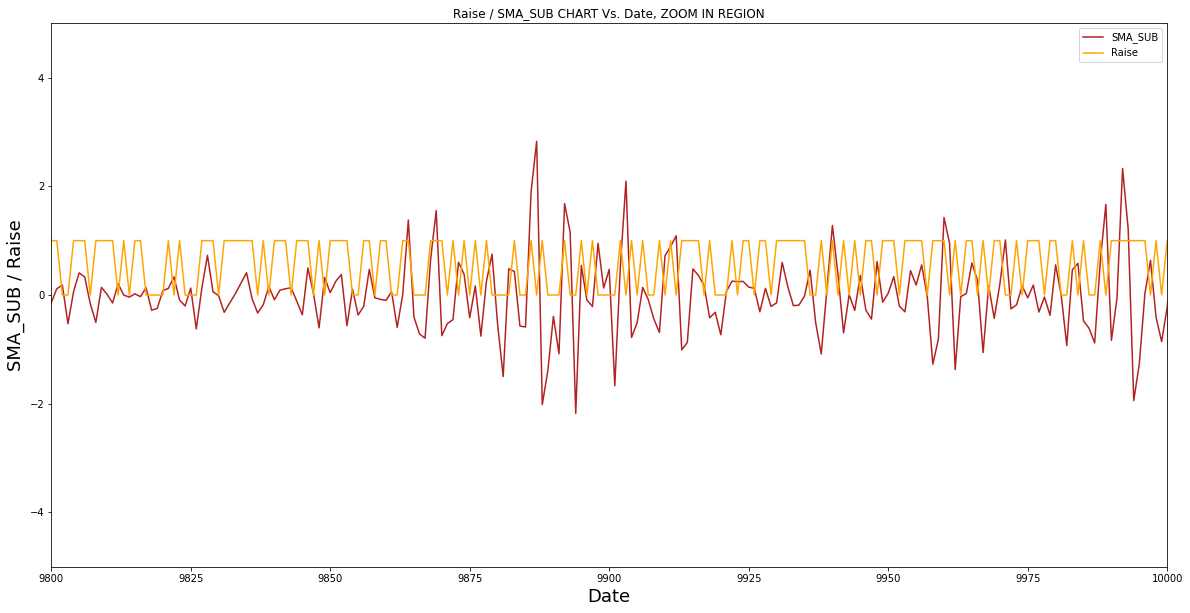

In [ ]:
#graphing OBV_SUB vs Raise.
plt.figure(figsize=(20,10))
plt.title('Raise / SMA_SUB CHART Vs. Date, ZOOM IN REGION')
plt.plot(df['SMA_SUB'], label='SMA_SUB', color='firebrick')
plt.plot(df['Raise'], label='Raise', color='orange')
plt.xlim(9800,10000)
plt.ylim(-5,5)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=18)
plt.ylabel('SMA_SUB / Raise', fontsize = 18)

In the graph above we can see the relation between SMA_SUB to Raise.

Text(0, 0.5, 'OBV')

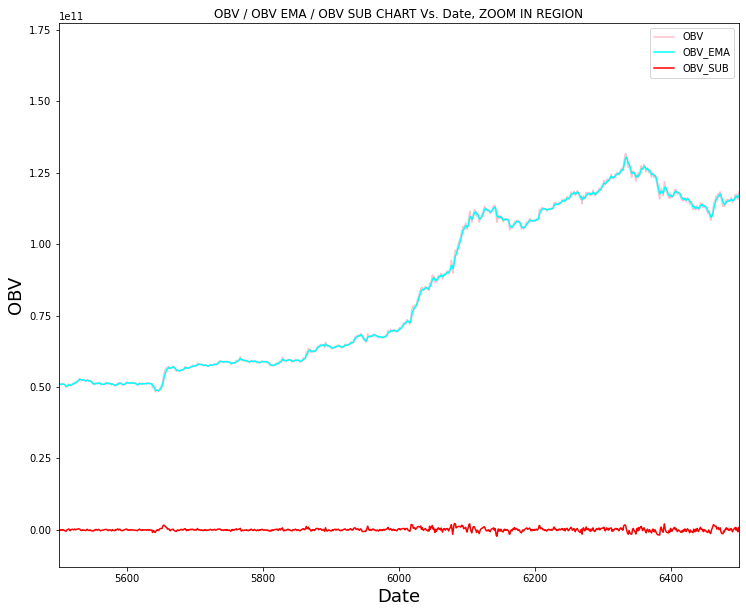

In [ ]:
#let's add one more indicator to our features' arsenal

#Calculation of On Balance Volume [3] (See References):
#If the closing price is above the prior close price then: Current OBV = Previous OBV + Current Volume
#If the closing price is below the prior close price then: Current OBV = Previous OBV - Current Volume
#If the closing prices equals the prior close price then: Current OBV = Previous OBV (no change)

OBV = []
OBV.append(0)
for i in range(dfrowsold-dfrowsnew+1 , nullrow):
  if df.Close[i] > df.Close[i-1]:
    OBV.append(OBV[-1] + df.Volume[i])
  elif df.Close[i] < df.Close[i-1]: 
    OBV.append(OBV[-1] - df.Volume[i])
  else:
    OBV.append(OBV[-1])
l=len(OBV)
for i in range(nullrow , dfrowsold):
  if i == nullrow:
    OBV.append(OBV[l-1])
  elif i == nullrow+1:
    OBV.append(OBV[l-1])
  elif df.Close[i] > df.Close[i-1]:
    OBV.append(OBV[-1] + df.Volume[i])
  elif df.Close[i] < df.Close[i-1]: 
    OBV.append(OBV[-1] - df.Volume[i])
  else:
    OBV.append(OBV[-1])
len(OBV)
#let's store the OBV and the EMA (exponential moving average) into new columns. [4] 
df['OBV'] = OBV
df['OBV_EMA'] = df['OBV'].ewm(span=4).mean()
df['OBV_SUB'] = df['OBV']-df['OBV_EMA']
#graphing OBV & OBV_EMA vs. Timeline
plt.figure(figsize=(12.2,10))
plt.title('OBV / OBV EMA / OBV SUB CHART Vs. Date, ZOOM IN REGION')
plt.plot(df['OBV'], label='OBV', color = 'pink')
plt.plot(df['OBV_EMA'], label='OBV_EMA', color='cyan')
plt.plot(df['OBV_SUB'], label='OBV_SUB', color='red')
plt.xlim(5500,6500)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=18)
plt.ylabel('OBV', fontsize = 18)

Text(0, 0.5, 'OBV_SUB / Raise')

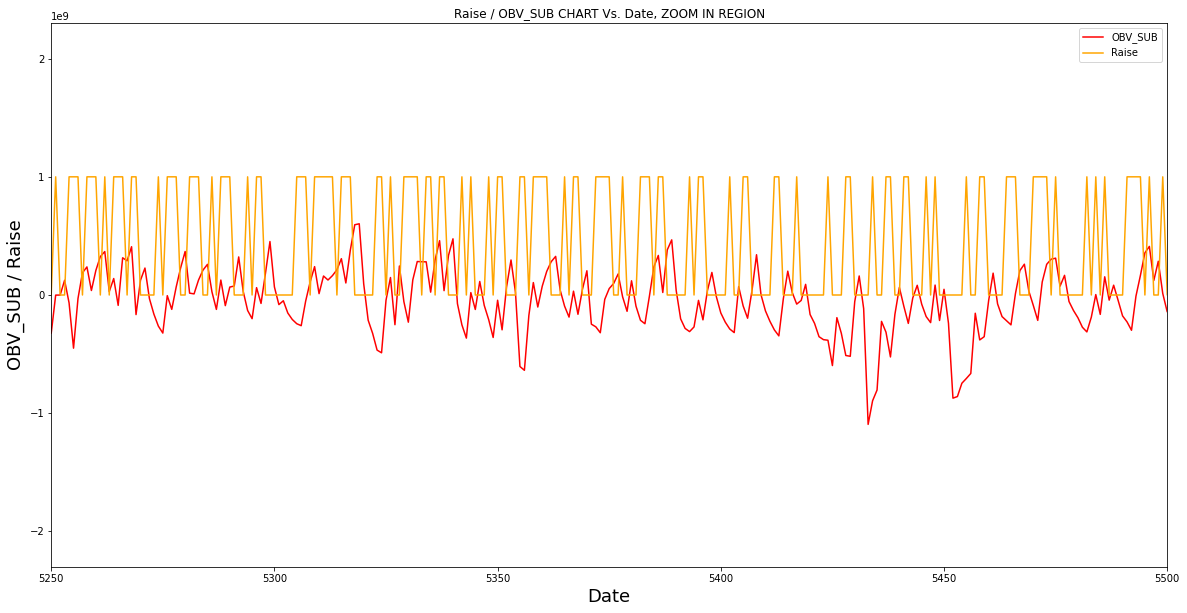

In [ ]:
#graphing OBV_SUB vs Raise.
plt.figure(figsize=(20,10))
plt.title('Raise / OBV_SUB CHART Vs. Date, ZOOM IN REGION')
plt.plot(df['OBV_SUB'], label='OBV_SUB', color='red')
plt.plot(df['Raise']*1000000000, label='Raise', color='orange')
plt.xlim(5250,5500)
plt.ylim(-2300000000,2300000000)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=18)
plt.ylabel('OBV_SUB / Raise', fontsize = 18)

In the graph above we can see the relation between OBV_SUB to Raise.

Text(0, 0.5, 'RSI_2 / Raise')

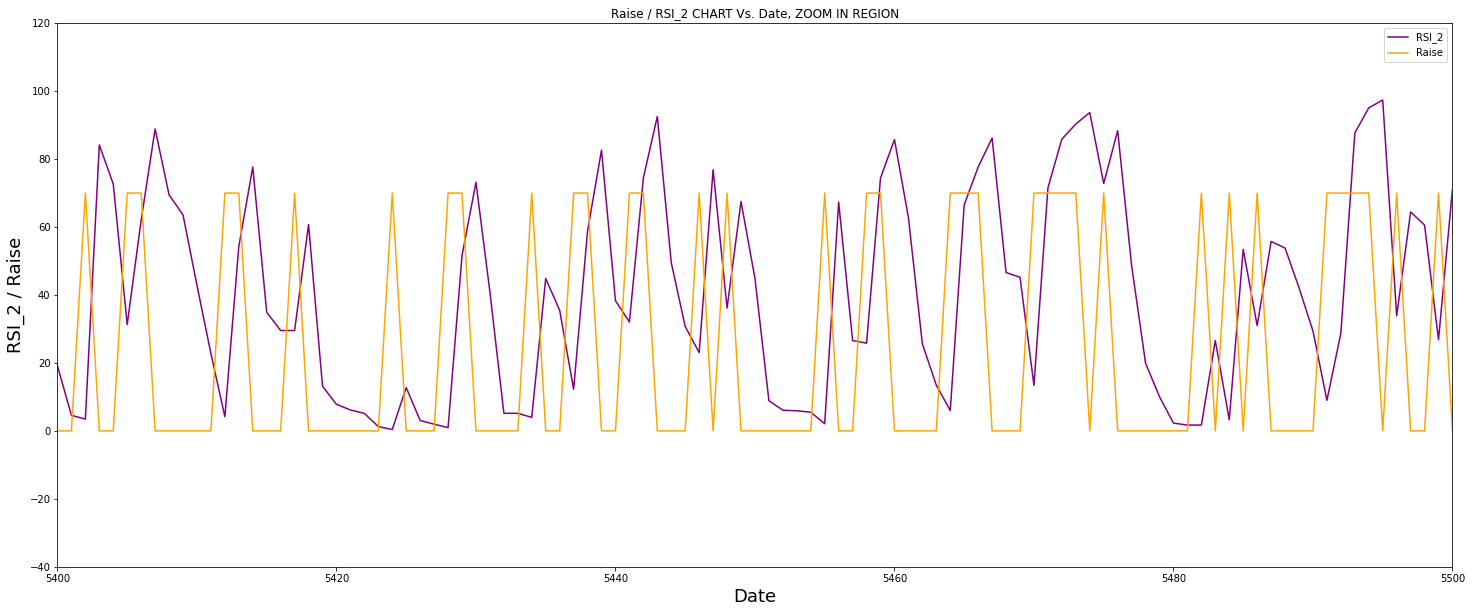

In [ ]:
#graphing RSI_2 vs Raise.
plt.figure(figsize=(25,10))
plt.title('Raise / RSI_2 CHART Vs. Date, ZOOM IN REGION')
plt.plot(df['RSI_2'], label='RSI_2', color='purple')
plt.plot(df['Raise']*70, label='Raise', color='orange')
plt.xlim(5400,5500)
plt.ylim(-40,120)
plt.legend(loc='best')
plt.xlabel('Date', fontsize=18)
plt.ylabel('RSI_2 / Raise', fontsize = 18)

In the graph above we can see the relation between RSI_2 to Raise.

In [ ]:
# Our new DataFrame

df

,Date,Open,Mid,High,Low,Close,Adj Close,Volume,Raise,Day,Month,Year,RSI_4,RSI_2,SMA_4,SMA_2,SMA_SUB,OBV,OBV_EMA,OBV_SUB
4,18/12/1980,0.118862,0.119141,0.119420,0.118862,0.118862,0.093777,73449600.0,1,5,12,1980,40.946642,60.716676,0.061245,0.059431,0.001814,0.000000e+00,0.000000e+00,0.000000e+00
5,19/12/1980,0.126116,0.126395,0.126674,0.126116,0.126116,0.099500,48630400.0,1,6,12,1980,65.822746,86.249902,0.094308,0.122489,-0.028181,4.863040e+07,3.039400e+07,1.823640e+07
6,22/12/1980,0.132254,0.132533,0.132813,0.132254,0.132254,0.104343,37363200.0,1,2,12,1980,76.833681,93.452536,0.128767,0.129185,-0.000418,8.599360e+07,5.876114e+07,2.723246e+07
7,23/12/1980,0.137835,0.138114,0.138393,0.137835,0.137835,0.108746,46950400.0,1,3,12,1980,83.339997,96.646568,0.135323,0.135044,0.000279,1.329440e+08,9.285253e+07,4.009147e+07
8,24/12/1980,0.145089,0.145368,0.145647,0.145089,0.145089,0.114469,48003200.0,1,4,12,1980,88.794229,98.521513,0.143415,0.141462,0.001953,1.809472e+08,1.310615e+08,4.988567e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011,26/08/2020,126.180000,126.037498,126.992500,125.082497,126.522499,126.522499,163022400.0,0,4,8,2020,86.596768,85.285161,126.679375,125.438751,1.240624,1.597263e+11,1.596261e+11,1.002324e+08
10012,27/08/2020,127.142502,125.658749,127.485001,123.832497,125.010002,125.010002,155552400.0,0,5,8,2020,68.696322,45.989523,126.008125,126.661251,-0.653126,1.598893e+11,1.597314e+11,1.579529e+08
10013,28/08/2020,126.012497,125.509998,126.442497,124.577499,124.807503,124.807503,187630000.0,1,6,8,2020,66.251621,40.938688,126.728750,126.577500,0.151251,1.597338e+11,1.597323e+11,1.440273e+06
10014,31/08/2020,127.580002,128.500000,131.000000,126.000000,129.039993,129.039993,225702700.0,1,2,8,2020,83.055952,89.436360,128.373749,126.796250,1.577500,1.595461e+11,1.596578e+11,-1.117138e+08


In [ ]:
#Choosing our features.
#After testing our features extensively, we have concluded that the following works best (from what we have tried, ofcourse)

#for Random Forest, and Neural Networks: features: Day, SMA_SUB, RSI_4, OBV, Open, Mid, RSI_2, OBV_SUB - 8 features
X = np.asarray(df.drop(['Date','Raise','High','Low','Adj Close','Close', 'SMA_4', 'SMA_2', 'Volume','OBV_EMA', 'Year','Month'],1))

#for Neural Networks with raw data, Low, High, Mid prices, Open, Close prices, Volume
Xx = np.asarray(df.drop(['Date','Raise','Adj Close','Day','Year','Month','RSI_4', 'SMA_4', 'SMA_2','OBV','OBV_EMA','RSI_2', 'SMA_2', 'OBV_SUB', 'SMA_SUB'],1))

#For Decision Tree and Logistic Regression, features: SMA_SUB, OBV - 2 features
XX = np.asarray(df.drop(['Date','Raise','High','Mid', 'Low','Adj Close','Open','Close','Day','Year','Month','Volume', 'RSI_4','RSI_2','SMA_4', 'SMA_2','OBV_SUB','OBV_EMA'],1))

print("number of features for RF, neural network is", X.shape[1])
print("number of features for DT is", XX.shape[1])

number of features for RF, neural network is 8
number of features for DT is 2


In [ ]:
#choosing the target

Y = np.asarray(df['Raise'])

In [ ]:
np.mean(Y), np.mean(1-Y)

(0.4960543402257517, 0.5039456597742483)

Above, we see that about 49.57% of the days in this dataset had indicated a raise in the stocks' price. This means we can get an accuracy of ~50% without any model.

Number of times price didnt go up the next day:  5045
Number of times price went up the next day :  4966


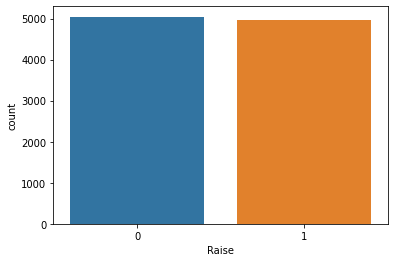

In [ ]:
p = df['Raise']
ax = sns.countplot(p,label="Raise")       # N = 5045, D = 4966
N, D = df['Raise'].value_counts()
print('Number of times price didnt go up the next day: ',N)
print('Number of times price went up the next day : ',D)

**2-3) Using Decision Tree and Logistic Regression**

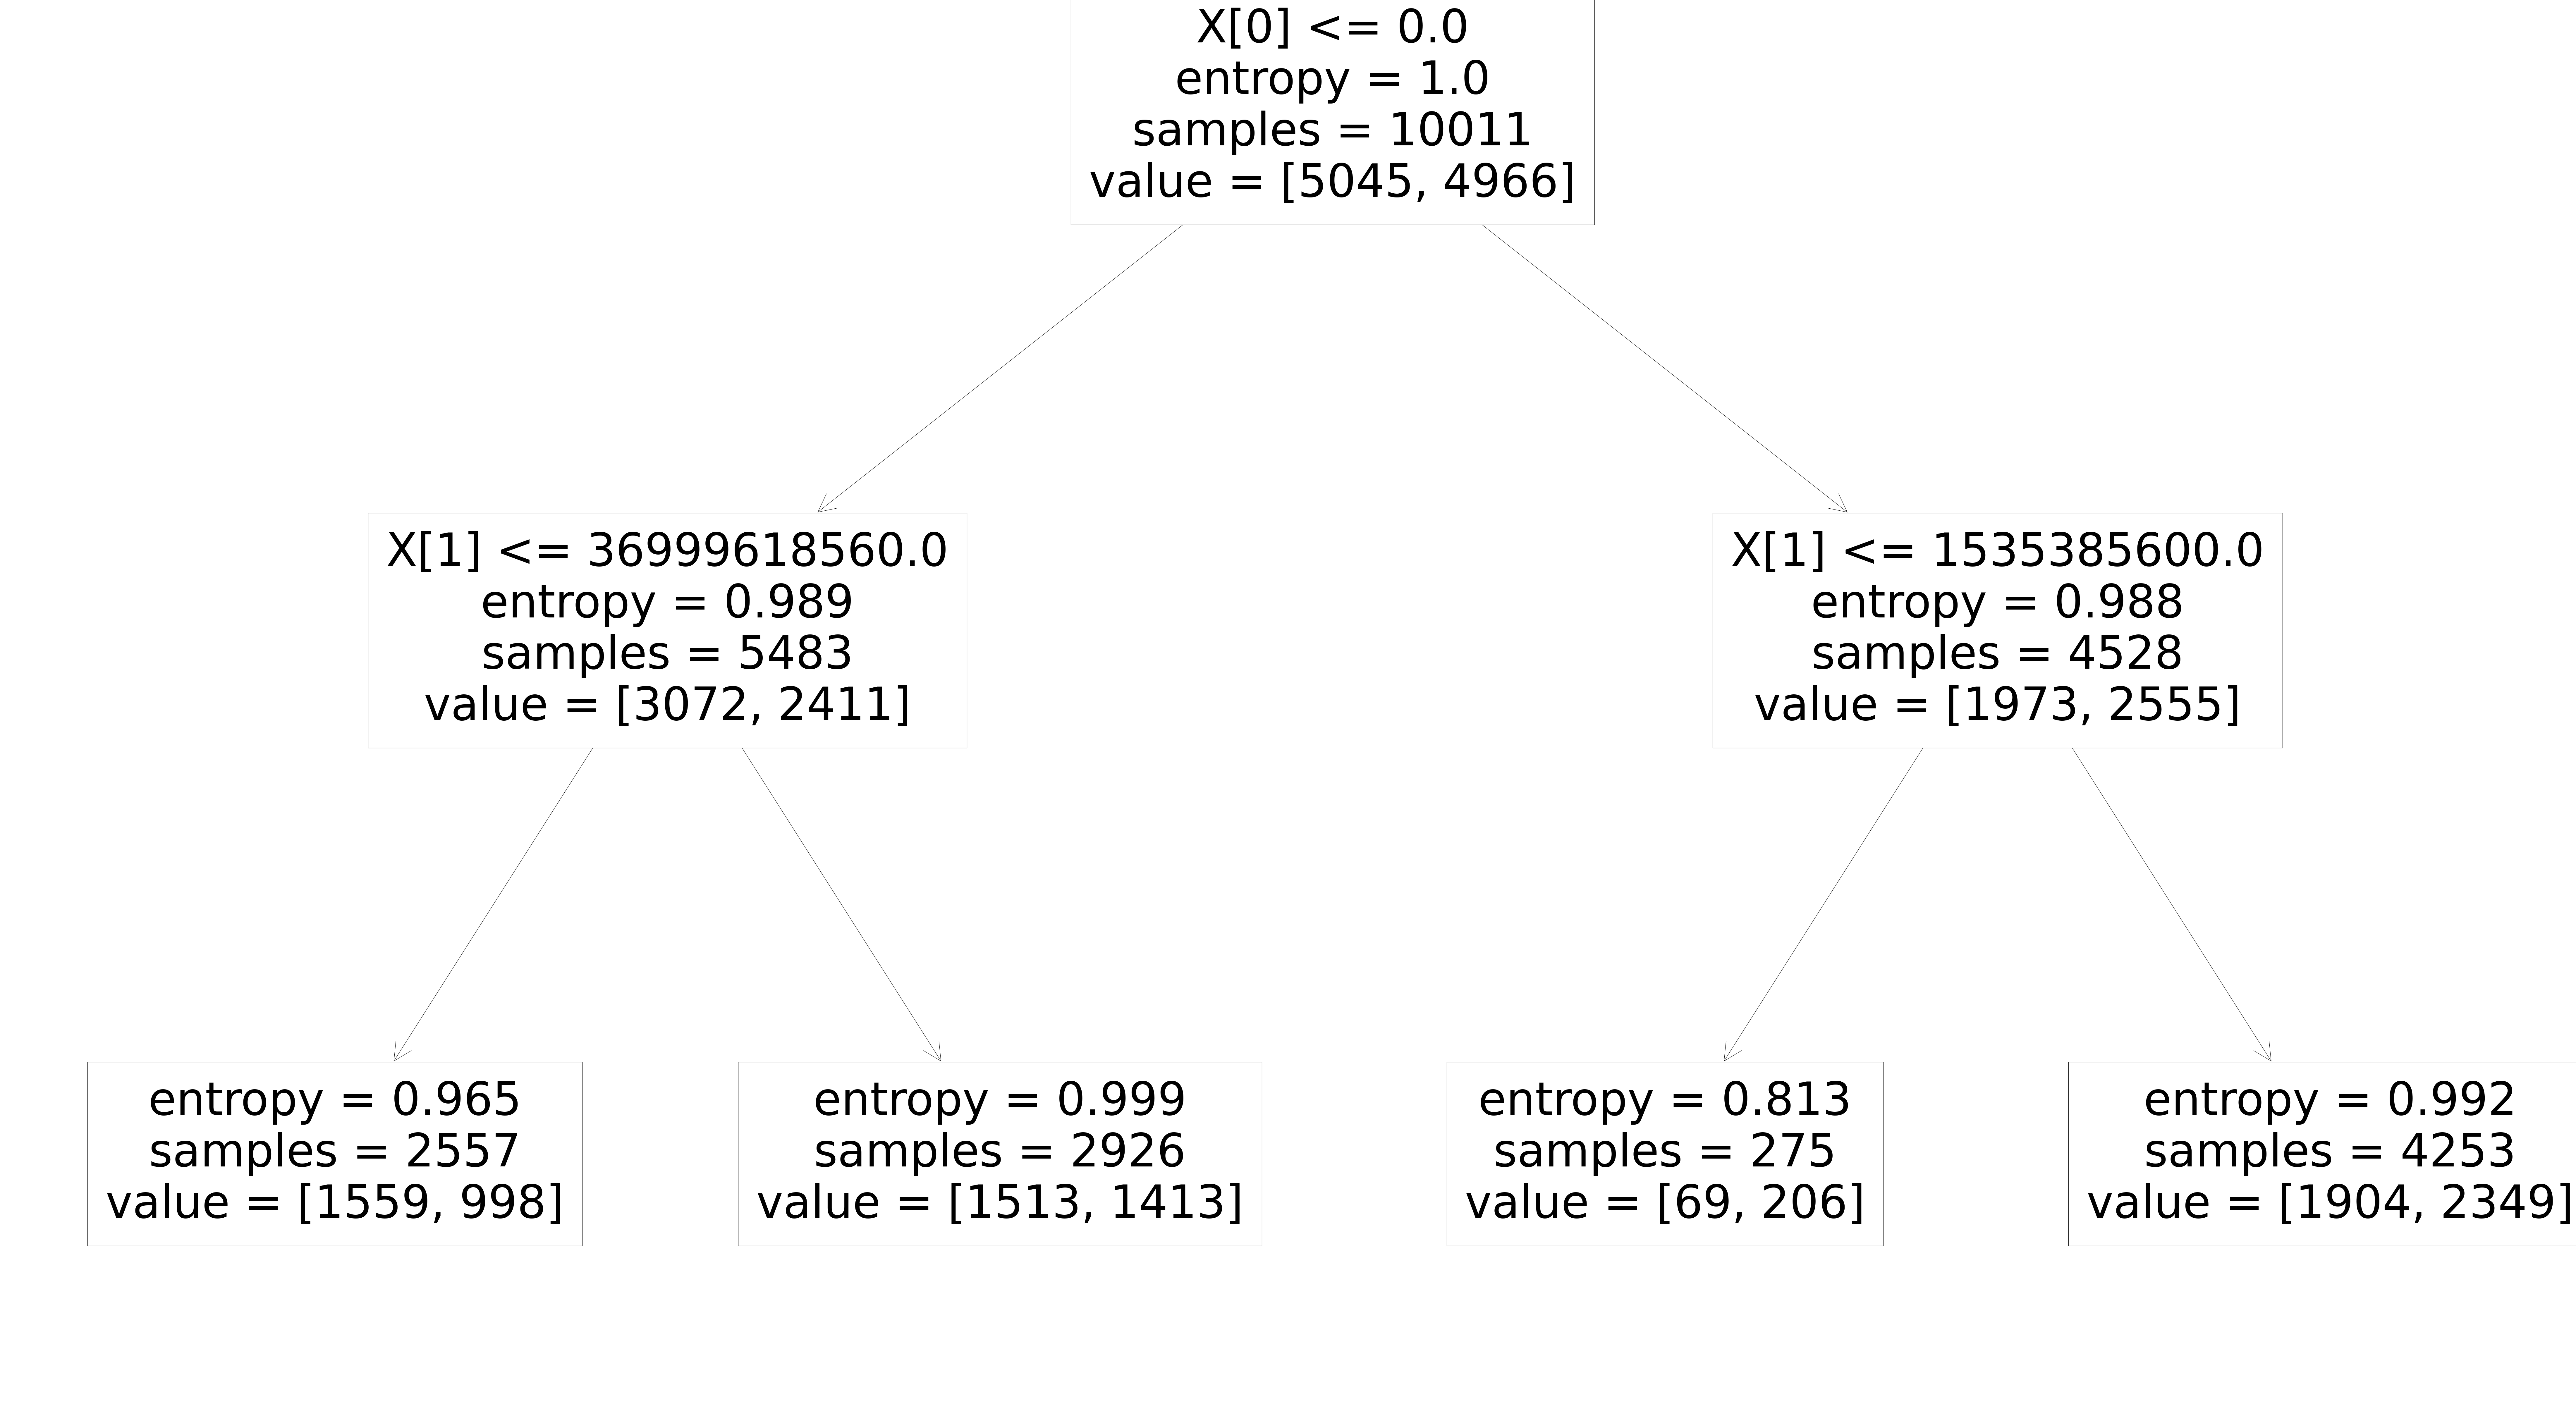

Average Accuracy with CV, of DT with depth 2 is: 0.552
Average Accuracy without CV, of DT with depth 2 is: 0.562
Average precision_weighted of  DT with depth  2  is:  0.558
Average recall_weighted of  DT with depth  2  is:  0.552
Average f1 score with depth 2 is: 0.555


In [ ]:
model_tree = tree.DecisionTreeClassifier()
model_tree.max_depth = 2
model_tree.criterion = 'entropy'
model_tree = model_tree.fit(XX, Y)
plt.figure(figsize=(132, 80), dpi=80)
tree.plot_tree(model_tree)
plt.show()
ancv = model_tree.score(XX,Y)
accuracy = cross_val_score(model_tree, XX, Y, scoring='accuracy', cv=10)
print("Average Accuracy with CV, of DT with depth", model_tree.max_depth, "is:", round(accuracy.mean(),3))
print("Average Accuracy without CV, of DT with depth", model_tree.max_depth, "is:", round(ancv.mean(),3))
precision = cross_val_score(model_tree, XX, Y, scoring='precision_weighted', cv=10)
print("Average precision_weighted of  DT with depth ", model_tree.max_depth, " is: ", round(precision.mean(),3))
recall = cross_val_score(model_tree, XX, Y, scoring='recall_weighted', cv=10)
print("Average recall_weighted of  DT with depth ", model_tree.max_depth, " is: ", round(recall.mean(),3))
f1 = 2*recall.mean()*precision.mean()/(recall.mean()+precision.mean())
print("Average f1 score with depth",model_tree.max_depth, "is:", round(f1.mean(),3))

Notice that the accuracy is lower with cross validation. Using the default cv=5 even results in a lower accuracy of 0.525. This may indicate in model overfitting although our confusion matrix doesn't indicate overfitting. We shall try Random Forest later on as it has a lower risk of overfitting.

[[3072 1973]
 [2411 2555]]


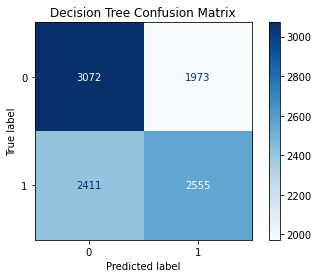

In [ ]:
disp = plot_confusion_matrix(model_tree, XX, Y,
                              display_labels=('0', '1'),
                              cmap=plt.cm.Blues)
print(disp.confusion_matrix)
plt.title("Decision Tree Confusion Matrix")
plt.show()

Let's see how Logistic Regression does:

In [ ]:
#newton-cg yields a slightly better result compared to the other solvers

model_lr = LogisticRegression(solver='newton-cg', max_iter=1000)
model_lr.fit(XX, Y)
accuracy = model_lr.score(XX, Y)
print("Average Accuracy of logistic without CV at is: ", round(accuracy.mean(),3))
accuracy = cross_val_score(model_lr, XX, Y, scoring='accuracy', cv=10)
print("Average Accuracy of logistic with CV is: ", round(accuracy.mean(),3))

Average Accuracy of logistic without CV at is:  0.501
Average Accuracy of logistic with CV is:  0.501


[[ 255 4790]
 [ 210 4756]]


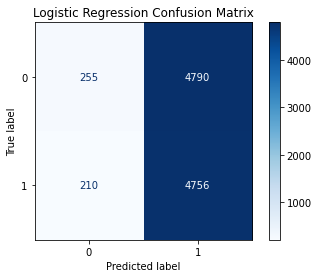

In [ ]:
disp = plot_confusion_matrix(model_lr, XX, Y,
                              display_labels=('0', '1'),
                              cmap=plt.cm.Blues)
print(disp.confusion_matrix)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

This model predics that the stocks' prices go up no matter what. Funny enough, its true in the long run for alot of stocks. This might actually be the result of the change of value of our money as the years goes by. That is, with ten bucks, you can't buy the same things you could buy a decade ago. But its a matter of interpertation. Anyhow this model doesn't work for our purpose. 

**4-6) RF & Using Keras to Build and Train Neural Networks**

First, let's get a baseline performance using Random Forest

In [ ]:
# Split the data to Train, and Test (80%, 20%)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=11111)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [ ]:
# Make predictions on the test set - both "hard" predictions, and the scores.
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

accuracy is 0.544
roc-auc is 0.566


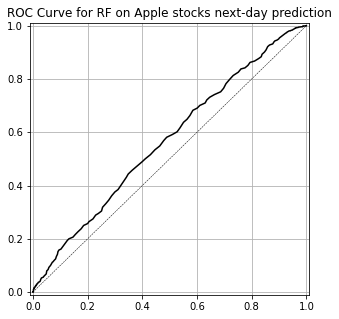

In [ ]:
# Print model performance and plot the roc curve
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on Apple stocks next-day prediction'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
    
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

Let's use the Keras package to quickly build and train a neural network

In [ ]:
## This aids   by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

After trying many different neual network structures, the following worked the best for us.

In [ ]:
# Define the Model 
# Input size is 8-dimensional
# 3 hidden layers, 192 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)
model_1 = Sequential([
    Dense(128, input_shape=(X_train_norm.shape[1],),activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])
print("input size is",X_train_norm.shape[1],"dimensional")

input size is 8 dimensional


In [ ]:
# This is a nice tool to view the model you have created and count the parameters
model_1.summary()

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_287 (Dense)           (None, 128)               1152      
                                                                 
 dense_288 (Dense)           (None, 32)                4128      
                                                                 
 dense_289 (Dense)           (None, 32)                1056      
                                                                 
 dense_290 (Dense)           (None, 1)                 33        
                                                                 
Total params: 6,369
Trainable params: 6,369
Non-trainable params: 0
_________________________________________________________________


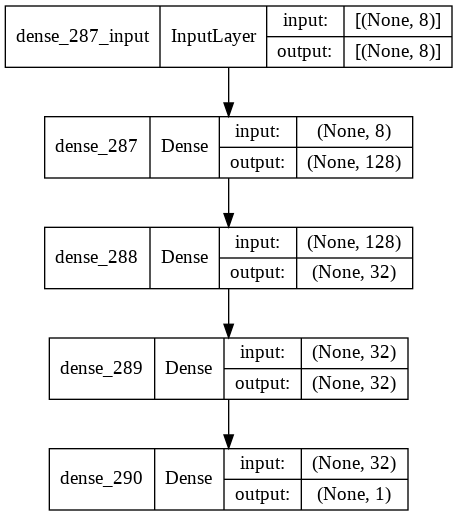

In [ ]:
# This is another tool to view the model you have created and count the parameters
plot_model(model_1, show_shapes=True, show_layer_names=True)

In [ ]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

#adding early stoppin to avoid over-fitting
callback = EarlyStopping(monitor='val_loss', patience=3)

model_1.compile(SGD(learning_rate = 0.001), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=100, batch_size=512, callbacks=[callback]) 
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/100
16/16 [==============================] - 1s 16ms/step - loss: 0.7119 - accuracy: 0.5036 - val_loss: 0.7111 - val_accuracy: 0.5082
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.7113 - accuracy: 0.5039 - val_loss: 0.7105 - val_accuracy: 0.5107
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.7108 - accuracy: 0.5035 - val_loss: 0.7100 - val_accuracy: 0.5102
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7102 - accuracy: 0.5031 - val_loss: 0.7095 - val_accuracy: 0.5102
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.7097 - accuracy: 0.5029 - val_loss: 0.7090 - val_accuracy: 0.5112
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.7092 - accuracy: 0.5022 - val_loss: 0.7085 - val_accuracy: 0.5112
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.7087 - accuracy: 0.5029 - val_loss: 0.7081 - val_accuracy: 0.5132
Epoch 8/100


In [ ]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

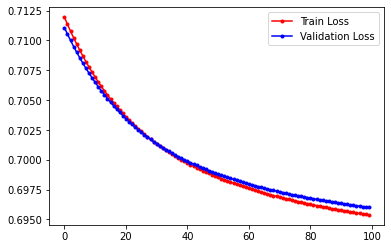

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [ ]:
## Use this in case the losses are still going down on both the training set and validation set in the graph above!
## Note that when we call "fit" again, it picks up where it left off

run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000, batch_size=512, callbacks=[callback])

Epoch 1/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.6953 - accuracy: 0.4998 - val_loss: 0.6960 - val_accuracy: 0.5082
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.5002 - val_loss: 0.6959 - val_accuracy: 0.5092
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.4998 - val_loss: 0.6959 - val_accuracy: 0.5092
Epoch 4/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.4994 - val_loss: 0.6959 - val_accuracy: 0.5092
Epoch 5/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.6952 - accuracy: 0.4990 - val_loss: 0.6958 - val_accuracy: 0.5092
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.6951 - accuracy: 0.4990 - val_loss: 0.6958 - val_accuracy: 0.5102
Epoch 7/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.4988 - val_loss: 0.6958 - val_accuracy: 0.5097
Epoch 

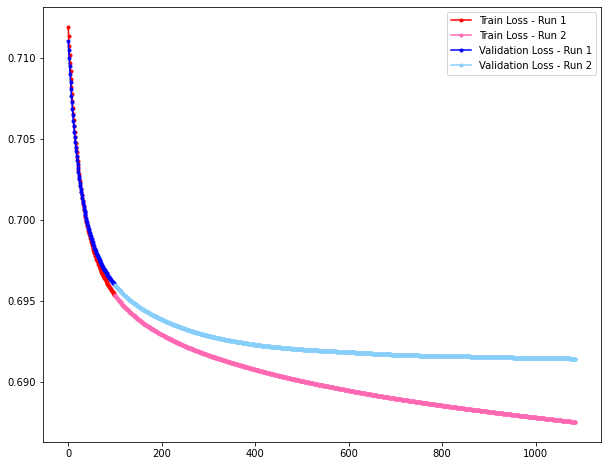

In [ ]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Both train and validation losses are going down, this indicates we don't have overfitting. Note that the training stopped at 986/1000 epochs that is because of the EarlyStopping we've implemented to avoid overfitting problem.

accuracy is 0.524
roc-auc is 0.531


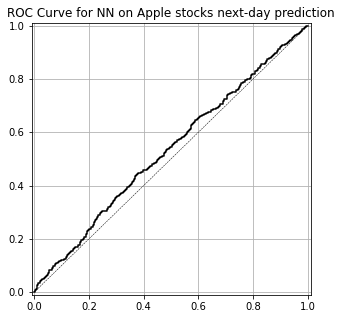

In [ ]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.
y_pred_class_nn_1 = (model_1.predict(X_test_norm) > 0.5).astype("int32") # Model does binary classification (e.g. if it uses a sigmoid last-layer activation).
y_pred_prob_nn_1 = model_1.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but we should get results similar to the Random Forest.

It is possible, ofcourse, to find a better set of neural network structure and to get even better results but since this project is for educational purposes we decided to leave it be.

Let's train a neural network this time with raw data only meaning without the indicators we have described earlier and compare the results. You'll see that the neural network hardly learns anything in this method as the accuracy is ~51%.

We'll use a different neural network model for this one to avoid overfitting.

In [ ]:
# Split the data to Train, and Test (80%, 20%)
X_train, X_test, y_train, y_test = train_test_split(Xx, Y, test_size=0.2, random_state=11111)

In [ ]:
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [ ]:
# Define the Model 
# Input size is 6-dimensional
# 4 hidden layers, 56 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)
model_1 = Sequential([
    Dense(32, input_shape=(X_train_norm.shape[1],),activation="relu"),
    Dense(1, activation="sigmoid")
])

In [ ]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(learning_rate = 0.001), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=100, batch_size=64)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/100
126/126 [==============================] - 1s 3ms/step - loss: 0.7336 - accuracy: 0.4780 - val_loss: 0.7298 - val_accuracy: 0.4828
Epoch 2/100
126/126 [==============================] - 0s 2ms/step - loss: 0.7217 - accuracy: 0.4771 - val_loss: 0.7188 - val_accuracy: 0.4823
Epoch 3/100
126/126 [==============================] - 0s 2ms/step - loss: 0.7131 - accuracy: 0.4765 - val_loss: 0.7109 - val_accuracy: 0.4828
Epoch 4/100
126/126 [==============================] - 0s 2ms/step - loss: 0.7071 - accuracy: 0.4753 - val_loss: 0.7055 - val_accuracy: 0.4823
Epoch 5/100
126/126 [==============================] - 0s 2ms/step - loss: 0.7031 - accuracy: 0.4748 - val_loss: 0.7018 - val_accuracy: 0.4818
Epoch 6/100
126/126 [==============================] - 0s 2ms/step - loss: 0.7003 - accuracy: 0.4738 - val_loss: 0.6992 - val_accuracy: 0.4833
Epoch 7/100
126/126 [==============================] - 0s 2ms/step - loss: 0.6983 - accuracy: 0.4745 - val_loss: 0.6975 - val_accuracy: 0.4843

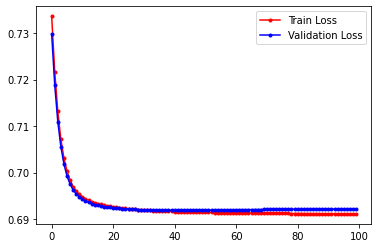

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

It looks like the validation loss has stabilized (or even gotten worse). This suggests that our network will not benefit from further training.

accuracy is 0.517
roc-auc is 0.525


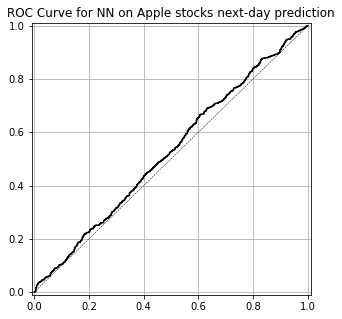

In [ ]:
y_pred_class_nn_1 = (model_1.predict(X_test_norm) > 0.5).astype("int32") # Model does binary classification (e.g. if it uses a sigmoid last-layer activation).
y_pred_prob_nn_1 = model_1.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

**7) Testing 1-6 on Amazon stocks**

In [ ]:
#getting the dataset
url = 'https://raw.githubusercontent.com/GilSasson/ai/main/Amazon.csv'
df=pd.read_csv(url,  header=0, error_bad_lines=False) 
#put data in dataset without header line
# rawdataset = np.array(df)

The following code is used if there are null rows in the dataset.
Since there aren't any in the Amazon dataset it has no use

In [ ]:
# #there aren't any null rows in this dataset.

# print("shape off dataframe before drop:",df.shape)
# # print("shape of np before drop:",rawdataset.shape)
# null_row = np.where(df['Low'].isnull()) 
# # dataset = np.delete(rawdataset,(null_row[0][0]), axis=0)
# # print("shape of np after drop:",dataset.shape)
# df.drop(null_row[0][0], axis=0, inplace = True)
# print("shape of dataframe after drop:",df.shape)
# print("row where we found null is:")
# nullrow = null_row[0][0] # we had a null row here
# nullrow

In [ ]:
#Creating new features with our given data:
High = df['High'].to_numpy()
Low = df['Low'].to_numpy()
Mid = (High+Low)/2.0
Close = df['Close'].to_numpy()
Open = df['Open'].to_numpy()
Volume = df['Volume'].to_numpy()
df.insert(2, "Mid", Mid, True)
df['RSI_4'] = computeRSI(df['Adj Close'], 4)
df['RSI_2'] = computeRSI(df['Adj Close'], 2)

In [ ]:
#dropping nan values if such exists from df

print("shape off dataframe before drop:",df.shape)
dfrowsold = df.shape[0] # will be used for OBV calc
df.dropna(subset = ["RSI_4"], inplace=True)
print("shape of dataframe after drop:",df.shape)
dfrowsnew = df.shape[0] # will be used for OBV calc

shape off dataframe before drop: (5852, 14)
shape of dataframe after drop: (5848, 14)


In [ ]:
#Creating new features with our given data:
df['SMA_4'] = movingaverage(df['Open'], 4)
df['SMA_2'] = movingaverage(df['Open'], 2)
df['SMA_SUB'] = df['SMA_4']-df['SMA_2']

We had to adjust the code below and is slightly different than the one in the Apple stocks example because we had no null rows in the Amazon dataset.

In [ ]:
#Calculation of On Balance Volume [3] (See References):
#If the closing price is above the prior close price then: Current OBV = Previous OBV + Current Volume
#If the closing price is below the prior close price then: Current OBV = Previous OBV - Current Volume
#If the closing prices equals the prior close price then: Current OBV = Previous OBV (no change)

OBV = []
OBV.append(0)
for i in range(5, len(df.Close)+4):
  if df.Close[i] > df.Close[i-1]:
    OBV.append(OBV[-1] + df.Volume[i])
  elif df.Close[i] < df.Close[i-1]: 
    OBV.append(OBV[-1] - df.Volume[i])
  else:
    OBV.append(OBV[-1])

len(OBV)
#let's store the OBV and the EMA (exponential moving average) into new columns. [4] 
df['OBV'] = OBV
df['OBV_EMA'] = df['OBV'].ewm(span=4).mean()
df['OBV_SUB'] = df['OBV']-df['OBV_EMA']

In [ ]:
# Our new DataFrame

df

,Date,Open,Mid,High,Low,Close,Adj Close,Volume,Raise,Day,Month,Year,RSI_4,RSI_2,SMA_4,SMA_2,SMA_SUB,OBV,OBV_EMA,OBV_SUB
4,21/05/1997,1.635417,1.510417,1.645833,1.375000,1.427083,1.427083,18853200,0,4,5,1997,0.000000,0.000000,0.768229,0.817708,-0.049479,0,0.000000e+00,0.000000e+00
5,22/05/1997,1.437500,1.380208,1.447917,1.312500,1.395833,1.395833,11776800,1,5,5,1997,0.000000,0.000000,1.119792,1.536458,-0.416667,-11776800,-7.360500e+06,-4.416300e+06
6,23/05/1997,1.406250,1.427083,1.520833,1.333333,1.500000,1.500000,15937200,1,6,5,1997,30.953443,54.982867,1.497396,1.421875,0.075521,4160400,-1.482490e+06,5.642890e+06
7,27/05/1997,1.510417,1.552083,1.645833,1.458333,1.583333,1.583333,8697600,0,3,5,1997,48.091840,76.051144,1.494792,1.458333,0.036458,12858000,5.107809e+06,7.750191e+06
8,28/05/1997,1.625000,1.583333,1.635417,1.531250,1.531250,1.531250,4574400,0,4,5,1997,39.849214,47.981619,1.520834,1.567708,-0.046875,8283600,6.485234e+06,1.798366e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,10/08/2020,3170.310059,3137.015015,3172.510010,3101.520020,3148.159912,3148.159912,3167300,0,2,8,2020,48.438397,25.480648,3175.470032,3197.160034,-21.690003,2532424500,2.533896e+09,-1.471977e+06
5848,11/08/2020,3113.199951,3116.109986,3159.219971,3073.000000,3080.669922,3080.669922,3718100,1,3,8,2020,31.461303,8.445094,3153.880005,3141.755005,12.125000,2528706400,2.531820e+09,-3.114046e+06
5849,12/08/2020,3108.000000,3137.904908,3174.389893,3101.419922,3162.239990,3162.239990,3527200,0,4,8,2020,56.200039,65.003236,3143.625000,3110.599976,33.025024,2532233600,2.531986e+09,2.478922e+05
5850,13/08/2020,3182.989990,3186.260010,3217.520020,3155.000000,3161.020020,3161.020020,3149000,0,5,8,2020,55.798414,63.823880,3145.592468,3145.494995,0.097473,2529084600,2.530825e+09,-1.740665e+06


In [ ]:
#Choosing our features.
#After testing our features extensively, we have concluded that the following works best (from what we have tried, ofcourse)

#for Random Forest, and Neural Networks: features: Day, SMA_SUB, RSI_4, OBV, Open, Mid, RSI_2, OBV_SUB - 8 features
X = np.asarray(df.drop(['Date','Raise','High','Low','Adj Close','Close', 'SMA_4', 'SMA_2', 'Volume','OBV_EMA', 'Year','Month'],1))

#for Neural Networks with raw data, Low, High, Mid prices, Open, Close prices, Volume
Xx = np.asarray(df.drop(['Date','Raise','Adj Close','Day','Year','Month','RSI_4', 'SMA_4', 'SMA_2','OBV','OBV_EMA','RSI_2', 'SMA_2', 'OBV_SUB', 'SMA_SUB'],1))

#For Decision Tree and Logistic Regression, features: SMA_SUB, OBV_SUB - 2 features
XX = np.asarray(df.drop(['Date','Raise','High','Mid', 'Low','Adj Close','Open','Close','Day','Year','Month','Volume', 'RSI_4','RSI_2','SMA_4', 'SMA_2','OBV_SUB','OBV_EMA'],1))

print("number of features for RF, neural network is", X.shape[1])
print("number of features for DT is", XX.shape[1])

number of features for RF, neural network is 8
number of features for DT is 2


In [ ]:
#choosing the target

Y = np.asarray(df['Raise'])

In [ ]:
np.mean(Y), np.mean(1-Y)

(0.5088919288645691, 0.4911080711354309)

Number of times price didnt go up the next day:  2976
Number of times price went up the next day :  2872


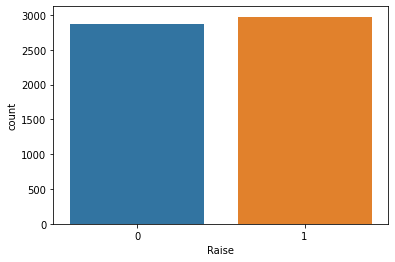

In [ ]:
p = df['Raise']
ax = sns.countplot(p,label="Raise")       # N = 2976, D = 2872
N, D = df['Raise'].value_counts()
print('Number of times price didnt go up the next day: ',N)
print('Number of times price went up the next day : ',D)

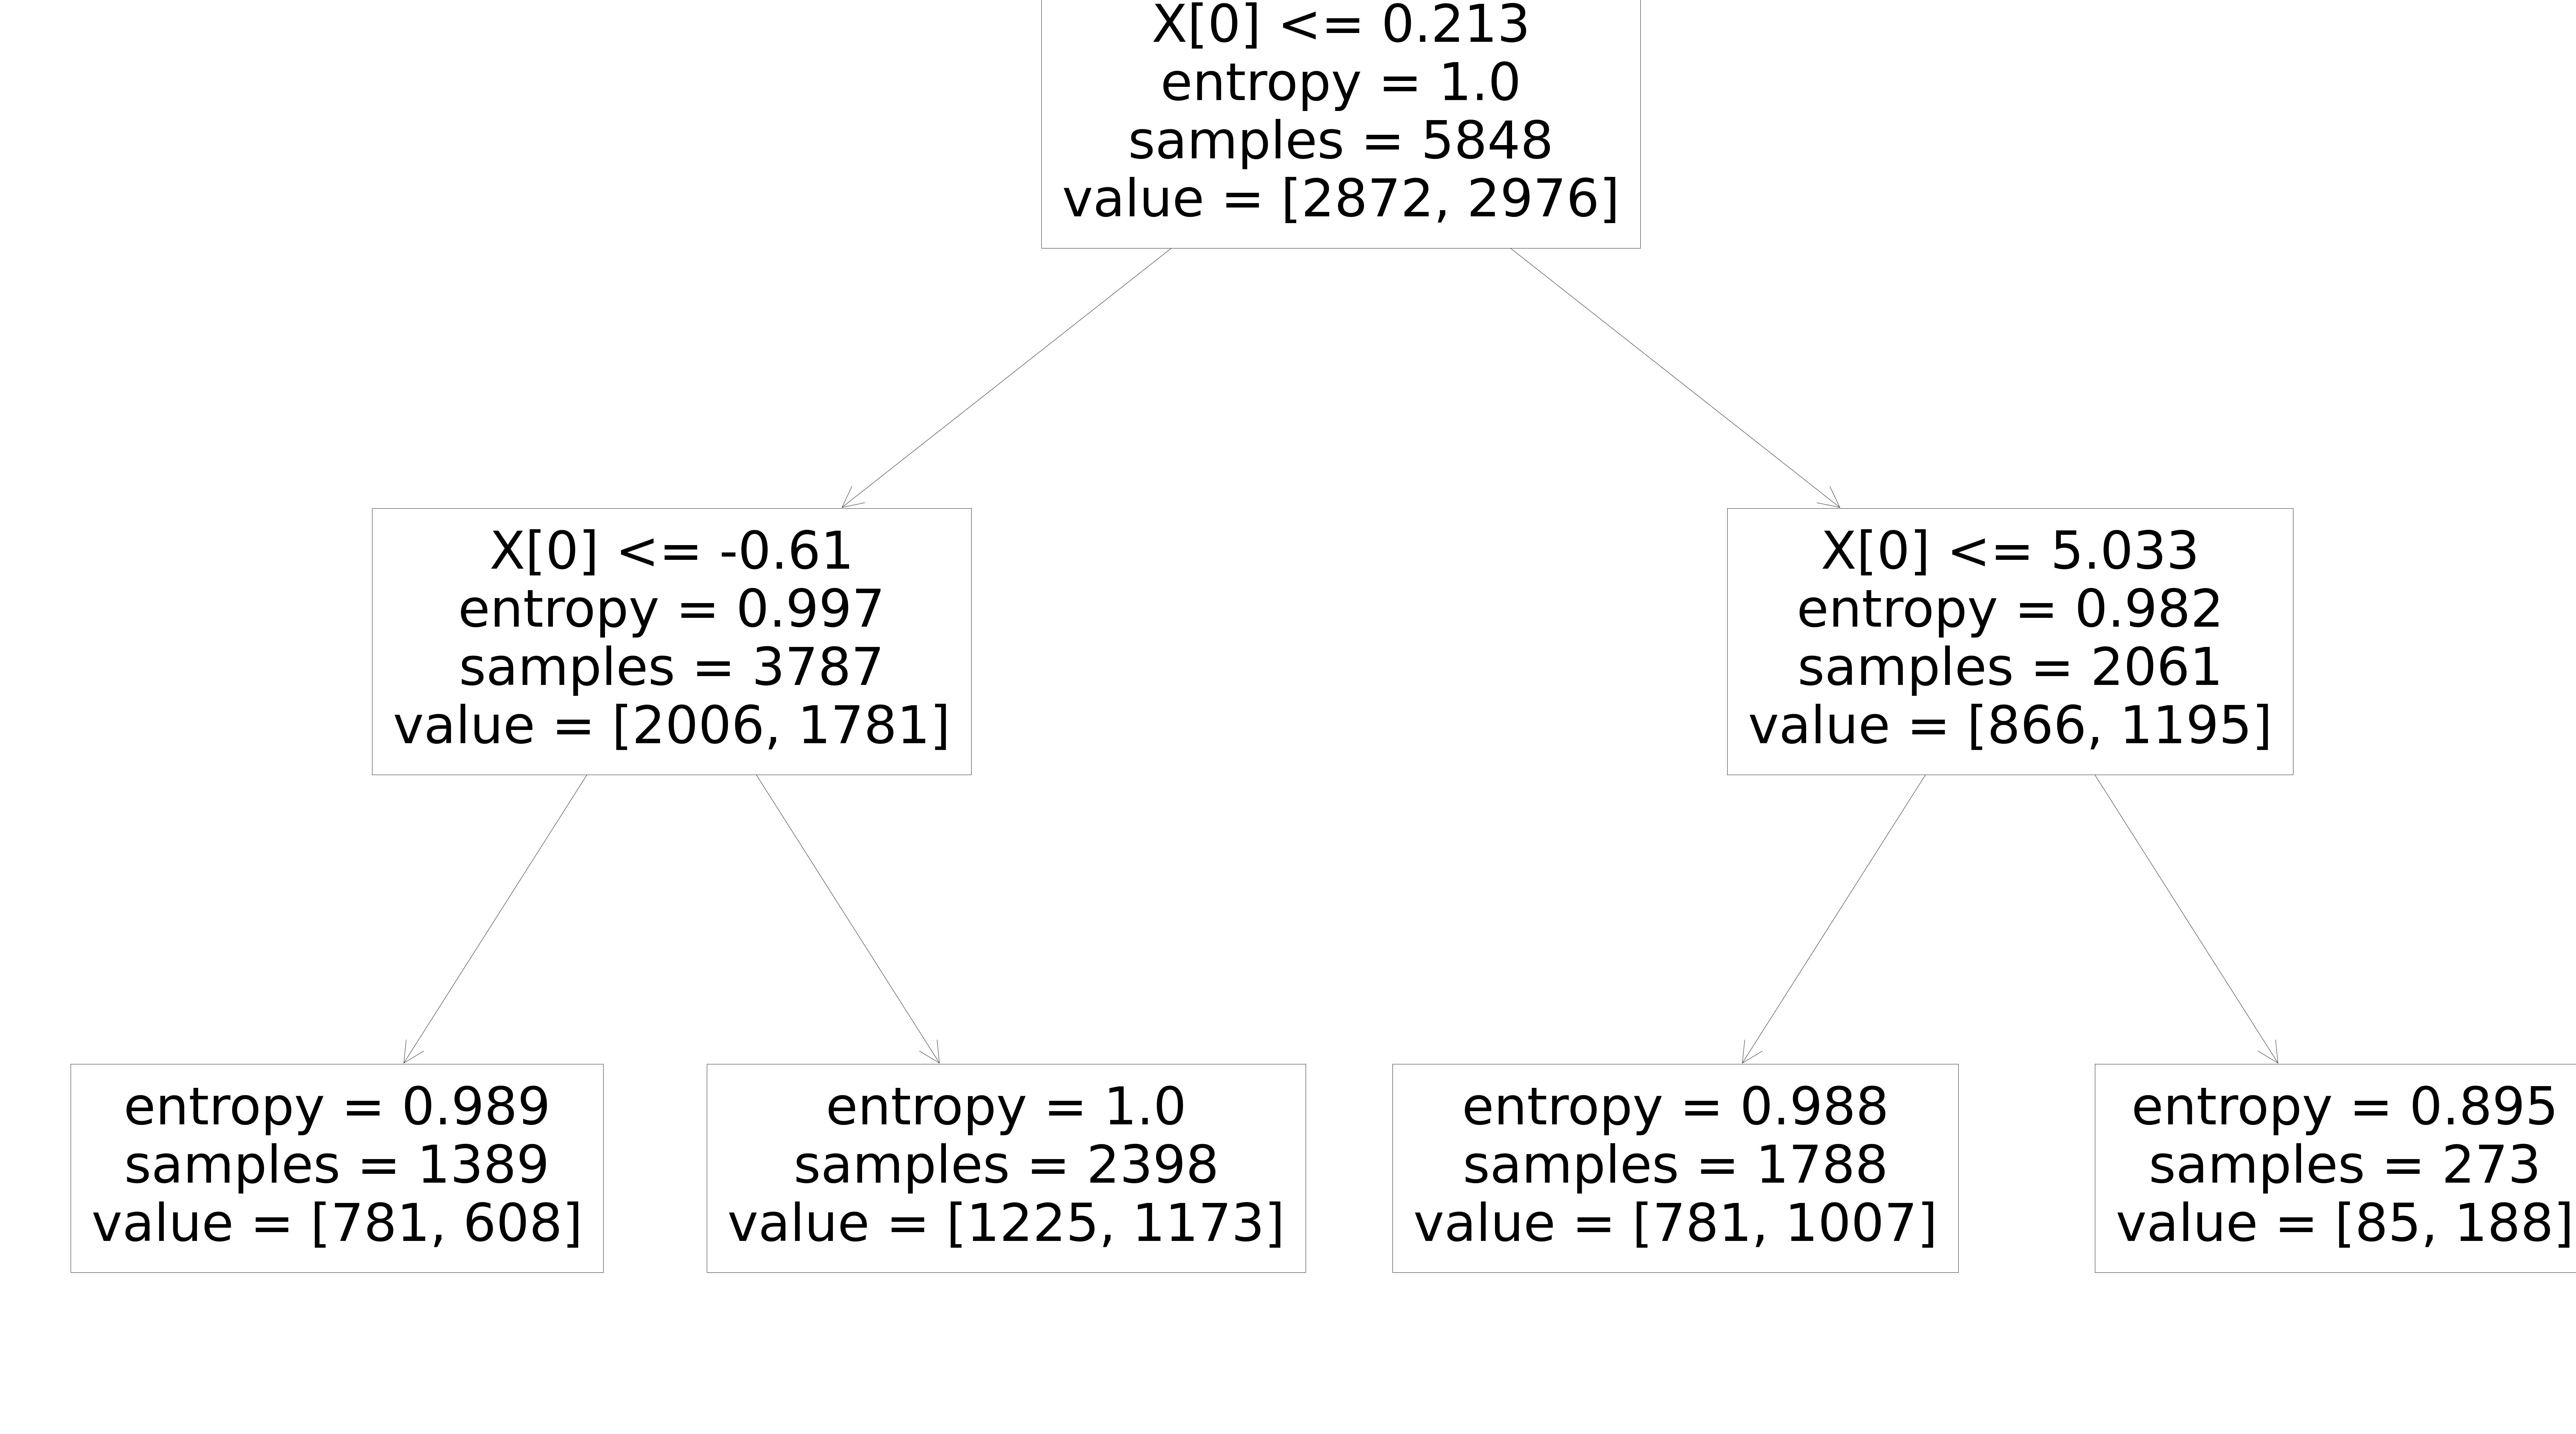

Average Accuracy with CV, of DT with depth 2 is: 0.532
Average Accuracy without CV, of DT with depth 2 is: 0.547
Average precision_weighted of  DT with depth  2  is:  0.51
Average recall_weighted of  DT with depth  2  is:  0.532
Average f1 score with depth 2 is: 0.521


In [ ]:
model_tree = tree.DecisionTreeClassifier()
model_tree.max_depth = 2
model_tree.criterion = 'entropy'
model_tree = model_tree.fit(XX, Y)
plt.figure(figsize=(132, 80), dpi=80)
tree.plot_tree(model_tree)
plt.show()
ancv = model_tree.score(XX,Y)
accuracy = cross_val_score(model_tree, XX, Y, scoring='accuracy', cv=10)
print("Average Accuracy with CV, of DT with depth", model_tree.max_depth, "is:", round(accuracy.mean(),3))
print("Average Accuracy without CV, of DT with depth", model_tree.max_depth, "is:", round(ancv.mean(),3))
precision = cross_val_score(model_tree, XX, Y, scoring='precision_weighted', cv=10)
print("Average precision_weighted of  DT with depth ", model_tree.max_depth, " is: ", round(precision.mean(),3))
recall = cross_val_score(model_tree, XX, Y, scoring='recall_weighted', cv=10)
print("Average recall_weighted of  DT with depth ", model_tree.max_depth, " is: ", round(recall.mean(),3))
f1 = 2*recall.mean()*precision.mean()/(recall.mean()+precision.mean())
print("Average f1 score with depth",model_tree.max_depth, "is:", round(f1.mean(),3))

[[2006  866]
 [1781 1195]]


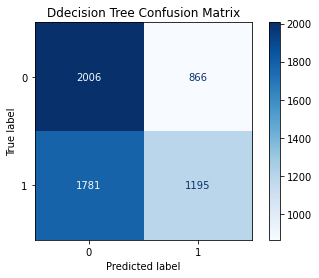

In [ ]:
disp = plot_confusion_matrix(model_tree, XX, Y,
                              display_labels=('0', '1'),
                              cmap=plt.cm.Blues)
print(disp.confusion_matrix)
plt.title("Ddecision Tree Confusion Matrix")
plt.show()

In [ ]:
#newton-cg yields a slightly better result compared to the other solvers

model_lr = LogisticRegression(solver='newton-cg', max_iter=1000)
model_lr.fit(XX, Y)
accuracy = model_lr.score(XX, Y)
print("Average Accuracy of logistic without CV at is: ", round(accuracy.mean(),3))
accuracy = cross_val_score(model_lr, XX, Y, scoring='accuracy', cv=10)
print("Average Accuracy of logistic with CV is: ", round(accuracy.mean(),3))

Average Accuracy of logistic without CV at is:  0.53
Average Accuracy of logistic with CV is:  0.52


[[ 955 1917]
 [ 829 2147]]


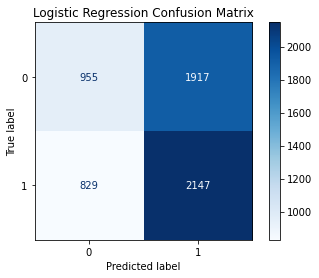

In [ ]:
disp = plot_confusion_matrix(model_lr, XX, Y,
                              display_labels=('0', '1'),
                              cmap=plt.cm.Blues)
print(disp.confusion_matrix)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

First, let's get a baseline performance using Random Forest

In [ ]:
# Split the data to Train, and Test (80%, 20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=11111)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [ ]:
# Make predictions on the test set - both "hard" predictions, and the scores.
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

accuracy is 0.531
roc-auc is 0.537


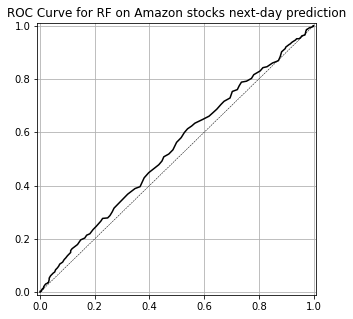

In [ ]:
# Print model performance and plot the roc curve
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on Amazon stocks next-day prediction'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
    
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

Let's use the Keras package to quickly build and train a neural network

In [ ]:
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [ ]:
# Define the Model 
# Input size is 6-dimensional
# 4 hidden layers, 56 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)
model_1 = Sequential([
    Dense(128, input_shape=(X_train_norm.shape[1],),activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])
print("input size is",X_train_norm.shape[1],"dimensional")

input size is 8 dimensional


In [ ]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

#adding early stoppin to avoid over-fitting
callback = EarlyStopping(monitor='val_loss', patience=3)

model_1.compile(SGD(learning_rate = 0.001), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=100, batch_size=128, callbacks=[callback]) 
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/100
37/37 [==============================] - 1s 8ms/step - loss: 0.7030 - accuracy: 0.5145 - val_loss: 0.7067 - val_accuracy: 0.4889
Epoch 2/100
37/37 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.5145 - val_loss: 0.7058 - val_accuracy: 0.4889
Epoch 3/100
37/37 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.5145 - val_loss: 0.7049 - val_accuracy: 0.4880
Epoch 4/100
37/37 [==============================] - 0s 4ms/step - loss: 0.7009 - accuracy: 0.5139 - val_loss: 0.7041 - val_accuracy: 0.4897
Epoch 5/100
37/37 [==============================] - 0s 3ms/step - loss: 0.7003 - accuracy: 0.5128 - val_loss: 0.7034 - val_accuracy: 0.4880
Epoch 6/100
37/37 [==============================] - 0s 3ms/step - loss: 0.6998 - accuracy: 0.5126 - val_loss: 0.7027 - val_accuracy: 0.4863
Epoch 7/100
37/37 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.5128 - val_loss: 0.7020 - val_accuracy: 0.4880
Epoch 8/100
3

In [ ]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = (model_1.predict(X_test_norm) > 0.5).astype("int32") # Model does binary classification (e.g. if it uses a sigmoid last-layer activation).
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

accuracy is 0.515
roc-auc is 0.546


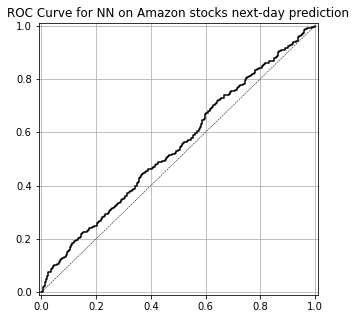

In [ ]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

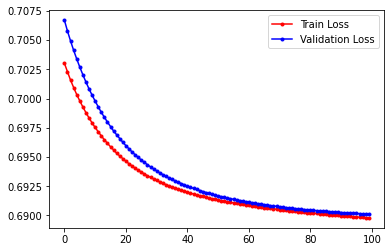

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [ ]:
## Use this in case the losses are still going down on both the training set and validation set in the graph above!
## Note that when we call "fit" again, it picks up where it left off

run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000, batch_size=128, callbacks=[callback])

Epoch 1/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.5316 - val_loss: 0.6901 - val_accuracy: 0.5154
Epoch 2/1000
37/37 [==============================] - 0s 5ms/step - loss: 0.6898 - accuracy: 0.5314 - val_loss: 0.6901 - val_accuracy: 0.5137
Epoch 3/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5321 - val_loss: 0.6901 - val_accuracy: 0.5145
Epoch 4/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5319 - val_loss: 0.6901 - val_accuracy: 0.5162
Epoch 5/1000
37/37 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5319 - val_loss: 0.6900 - val_accuracy: 0.5171
Epoch 6/1000
37/37 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5327 - val_loss: 0.6900 - val_accuracy: 0.5171
Epoch 7/1000
37/37 [==============================] - 0s 3ms/step - loss: 0.6897 - accuracy: 0.5336 - val_loss: 0.6900 - val_accuracy: 0.5179
Epoch 

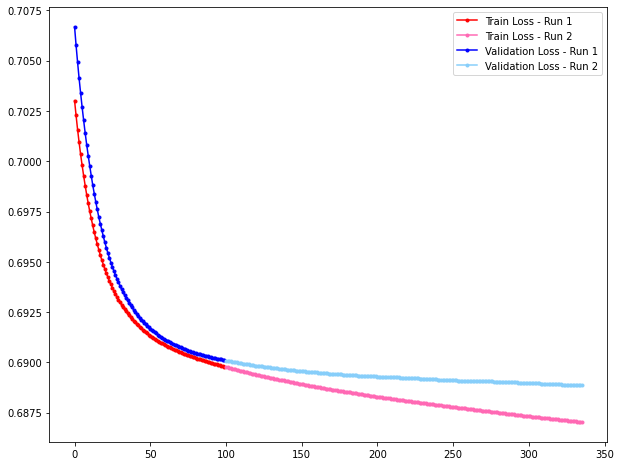

In [ ]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Both train and validation losses are going down, this indicates we don't have overfitting. Note that the training stopped at 236/1000 epochs that is because of the EarlyStopping we've implemented to avoid overfitting problem.

accuracy is 0.527
roc-auc is 0.550


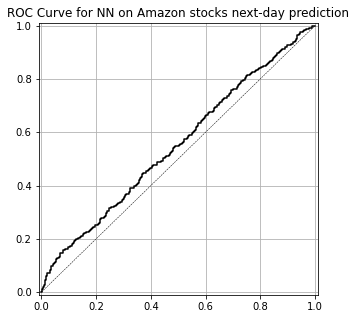

In [ ]:
y_pred_class_nn_1 = (model_1.predict(X_test_norm) > 0.5).astype("int32") # Model does binary classification (e.g. if it uses a sigmoid last-layer activation).
y_pred_prob_nn_1 = model_1.predict(X_test_norm)
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

# **Data Setup**
First we have updated the excel file by adding a new binary 'Raise' culomn which indicates if the stocks' price went up or not the next day. We did that using the 'Adj Close' culomn by checking if

AdjClose [j+1] > AdjClose [ j ]

Then Raise [ j ]=1, otherwise Raise [ j ]=0

We then created new fields like the day of the month and year.
We saw that using the raw data as is doesn't yield much of anything and training a neural network this way gives merely 51% accuracy which is equivalent to deciding the result by tossing a coin. We then added a 'Mid' prices culomn which is the maximum stocks' price plus the minimum stocks' price on a given day, divided by two

Mid [ j ] = (High [ j ] + Low [ j ]) / 2

Our models showed slightly better results thanks to the 'Mid' feature. That made us realize that creating new features is necessary and that indicators which are short-period based is probably the way to go to improving our models' accuracy.

We quickly learned that such stock market indicators already exists, no surprise there, and decided to try some of them. Relative Strength Indicator (RSI) [4], On-balance volume (OBV) [5] and Simple Moving Average [6] greatly improved our results.

In our Random Forest, Neural Network models we used just one train / test split whereas in our Logistic Regression, Decison Tree models we used cross-validation.

# **Machine Model Logic**

We tried different kind of machine models such as
Logistic Regression, Decision Tree, Random Forest & Neural Network.
Out of these methods, the Random Forest model performed the best as the Decision Tree's accuracy drops with cross-validation indicates that the Decision Tree's model is prone to overfitting. 

For our neural network we defined the following:

- Input size is 8-dimensional

- Three hidden ReLU activation layers, with a total of 192 hidden nodes (128-32-32)

- The final layer has just one node with a sigmoid activation

- SGD optimizer with learning rate of 0.001

- Binary cross entropy loss function

- Batch size = 128

- Early Stopping to avoid overfitting

# **References**

[1] https://tcoil.info/compute-rsi-for-stocks-with-python-relative-strength-index/

[2] https://www.youtube.com/watch?v=5-SV_xXQ_wE

[3] https://www.kaggle.com/kratisaxena/stock-market-technical-indicators-visualization/notebook

[4] https://www.youtube.com/watch?v=MRGXd8eaWB4

[5] https://en.wikipedia.org/wiki/Relative_strength_index

[6] https://en.wikipedia.org/wiki/On-balance_volume

[7] https://en.wikipedia.org/wiki/Moving_average
